    # Test 3: "Real-world" waveform with noise

Just like with the sinusoid test, we can use audio recordings of real-world sounds as a basis for testing the system performance on more complex waveforms, and add progressive levels of white noise for each iteration. 

In the "Data" folder you can find a number of audio files you can use as test input. Most of these files contain a short recording of a continuous musical note. If you wish to adjust the samping frequency of the sound files, take a look at the function [`resample`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) in the `scipy.signal` module.

Create a python program which lads a specific audio file and adds progressively increasing levels of white gaussian noise before feeding it into the attached function `freq_detection`. Subsequently, your program should provide an analysis of the outuput from the function `freq_detection` for the various noise levels, which can take the form of a plot showing the frequency detection system's error as a function of SNR. This will be useful when evaluating the frequency detection system's performance in the presence of noise. Measuring the frequency estimate error in such a way will allow us to evaluate two things:

1. How well the frequency detection system can estimate the fundamental frequency of a "real-world" periodic waveform
2. The effect of white noise interference on the frequency detection system when applied to a "real-world" periodic waveform

P.S. You can determine appropriate noise power(s) by calculating the average power in the audio clip as a basis for and scaling by desired SNR

95712


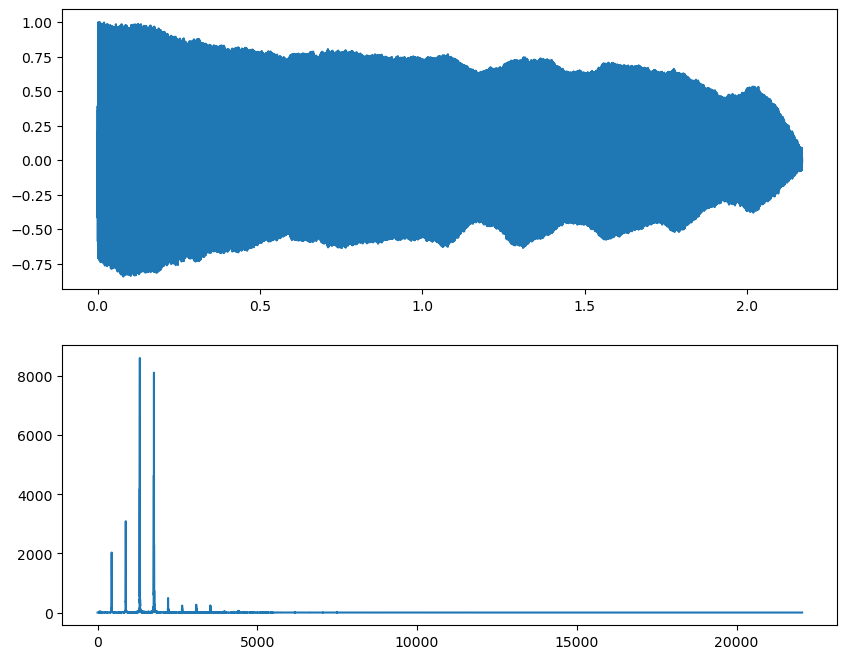

In [5]:
from baseline_algorithm import freq_detection
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# WRITE YOUR CODE IN THIS CELL:

fs, sampleData = sp.io.wavfile.read("sample_audio/A4_oboe.wav") # "fs" is sampling frequency, "sampleData" is the sequence of measurements
# Settings
sampleData = sampleData[10000:-10000]

sampleData = sampleData/max(abs(sampleData))    


N = len(sampleData)
print(N)

# Calculating Noise_Var
SNR = np.logspace(-2,2, num=100)
sig_pwr = np.mean(sampleData**2)
noise_vars = sig_pwr/(SNR)

# Calculating the fundamental frequency
Xm = sp.fft.fft(sampleData).__abs__()[:N//2] 
frequencies = sp.fft.fftfreq(N, 1 / fs)[:N//2] 

first_index = 0
for i in range(len(frequencies)):
    if Xm[i] > 0.3 * 10**8:
        first_index = i
        break
f = round(frequencies[first_index],1)

# Plotting to understand the signals
plt.close('all')
time = np.arange(N)/fs
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,8))
ax1.plot(time,sampleData)
ax2.plot(frequencies,Xm)
plt.show()


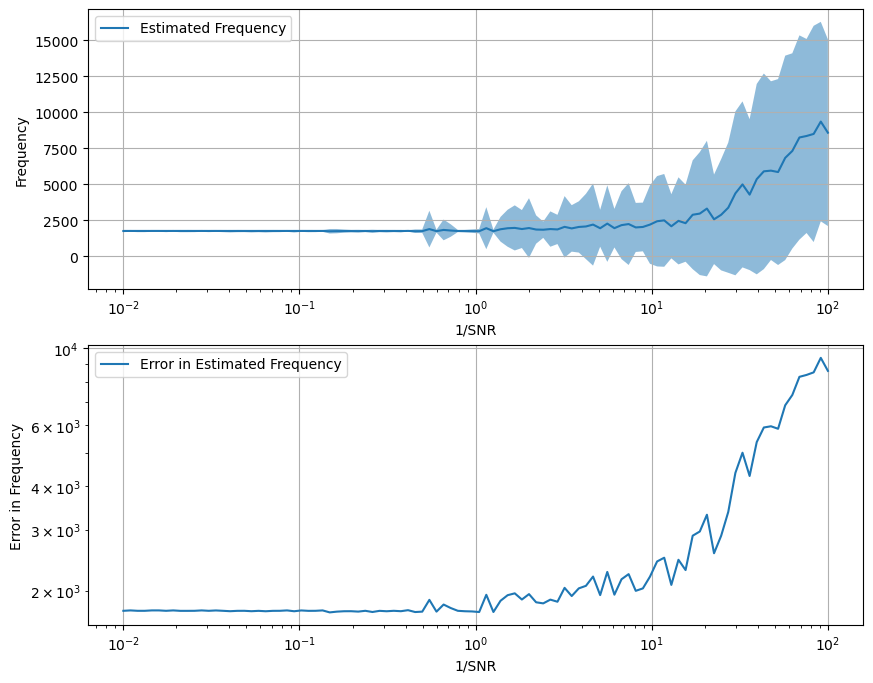

In [6]:
mean_f_est = np.array([])
std_f_est = np.array([])

####
# Why do we generate a new noise for every increase in power,
# instead of just adding together the same noise?
####

for noise_var in noise_vars:
    noise = np.random.normal(scale=np.sqrt(noise_var), size=(N)) 
    x_n = sampleData.copy() + noise.copy()
    t_est, f_est = freq_detection(x_n, fs)

    mean_f_est = np.append(mean_f_est, np.mean(f_est))
    std_f_est = np.append(std_f_est, np.std(f_est))


fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,8))
ax1.set_xscale('log')
ax1.plot(1/SNR, mean_f_est, label="Estimated Frequency")
ax1.fill_between(1/SNR,(mean_f_est+std_f_est),(mean_f_est-std_f_est),alpha=0.5)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('1/SNR')
ax1.grid()
ax1.legend()

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(1/SNR, np.abs(f-mean_f_est), label="Error in Estimated Frequency")
ax2.set_ylabel('Error in Frequency')
ax2.set_xlabel('1/SNR')
ax2.grid()
ax2.legend()

plt.show()

In [9]:
noise_vars

array([4.73980010e+00, 4.31872933e+00, 3.93506532e+00, 3.58548496e+00,
       3.26696036e+00, 2.97673260e+00, 2.71228788e+00, 2.47133570e+00,
       2.25178905e+00, 2.05174632e+00, 1.86947483e+00, 1.70339584e+00,
       1.55207085e+00, 1.41418915e+00, 1.28855648e+00, 1.17408468e+00,
       1.06978223e+00, 9.74745725e-01, 8.88152002e-01, 8.09251026e-01,
       7.37359395e-01, 6.71854419e-01, 6.12168724e-01, 5.57785342e-01,
       5.08233229e-01, 4.63083190e-01, 4.21944156e-01, 3.84459800e-01,
       3.50305451e-01, 3.19185280e-01, 2.90829739e-01, 2.64993227e-01,
       2.41451959e-01, 2.20002032e-01, 2.00457658e-01, 1.82649552e-01,
       1.66423469e-01, 1.51638867e-01, 1.38167688e-01, 1.25893252e-01,
       1.14709242e-01, 1.04518789e-01, 9.52336280e-02, 8.67733349e-02,
       7.90646310e-02, 7.20407471e-02, 6.56408457e-02, 5.98094939e-02,
       5.44961833e-02, 4.96548925e-02, 4.52436887e-02, 4.12243641e-02,
       3.75621052e-02, 3.42251913e-02, 3.11847197e-02, 2.84143551e-02,
      

[Here](Figures/wavfileTest_LF.png) is an image showing a *suggestion* for what or test output may look like when using the audio in `A4_oboe.wav` as a signal. As we can see, the frequency detection system produces a stable but erroneous output when there is little noise, suggesting it has "locked on" to a harmonic rather than the fundamental frequency. It is also interesting to note that the noise will begin to cause the estimated frequency to fluctuate a lot earlier than in the case with the pure sinusoid, so while the average error remains more or less unchanged, the estimated frequency will vary significantly.